# Lab 4: The Multi-Layer Perceptron
## by Michael Doherty, Leilani Guzman, and Carson Pittman

Our goal is to predict what the child poverty rate for each county in the United States will be.

Link to the dataset: https://www.kaggle.com/datasets/muonneutrino/us-census-demographic-data/data

## 1. Load, Split, and Balance
### 1.1 Loading the Data

To begin, we need to load in the data and store it in a Pandas dataframe.

In [184]:
import pandas as pd

df = pd.read_csv("data/acs2017_census_tract_data.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74001 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           74001 non-null  int64  
 1   State             74001 non-null  object 
 2   County            74001 non-null  object 
 3   TotalPop          74001 non-null  int64  
 4   Men               74001 non-null  int64  
 5   Women             74001 non-null  int64  
 6   Hispanic          73305 non-null  float64
 7   White             73305 non-null  float64
 8   Black             73305 non-null  float64
 9   Native            73305 non-null  float64
 10  Asian             73305 non-null  float64
 11  Pacific           73305 non-null  float64
 12  VotingAgeCitizen  74001 non-null  int64  
 13  Income            72885 non-null  float64
 14  IncomeErr         72885 non-null  float64
 15  IncomePerCap      73256 non-null  float64
 16  IncomePerCapErr   73256 non-null  float6

As shown above, there are several missing datapoints in the dataset; seeing as the dataset is so large, we will remove the observations that have missing data.

We also need to change the <code>State</code> and <code>County</code> attributes from strings to numeric data so we can use them in our neural network. For now, we will simply encode them as integers by mapping each string to an integer (such as mapping 'Alabama' to 1, 'Alaska' to 2, etc.).

In [185]:
# remove rows with missing data
df.dropna(inplace=True)

# convert 'State' strings to integers
unique_states = df['State'].unique()

state_to_int = { }

counter = 1

for state in unique_states:
    state_to_int[state] = counter
    counter += 1

# 'Alabama' = 1, 'Alaska' = 2, 'Arizona' = 3, etc.
df['State'] = df['State'].map(state_to_int)

# convert 'County' strings to integers
unique_counties = df['County'].unique()

county_to_int = { }

counter = 1

for county in unique_counties:
    county_to_int[county] = counter
    counter += 1
    
# 'Autauga County' = 1, 'Baldwin County' = 2, 'Barbour County' = 3, etc.
df['County'] = df['County'].map(county_to_int)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 72718 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           72718 non-null  int64  
 1   State             72718 non-null  int64  
 2   County            72718 non-null  int64  
 3   TotalPop          72718 non-null  int64  
 4   Men               72718 non-null  int64  
 5   Women             72718 non-null  int64  
 6   Hispanic          72718 non-null  float64
 7   White             72718 non-null  float64
 8   Black             72718 non-null  float64
 9   Native            72718 non-null  float64
 10  Asian             72718 non-null  float64
 11  Pacific           72718 non-null  float64
 12  VotingAgeCitizen  72718 non-null  int64  
 13  Income            72718 non-null  float64
 14  IncomeErr         72718 non-null  float64
 15  IncomePerCap      72718 non-null  float64
 16  IncomePerCapErr   72718 non-null  float64
 17

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,1,1,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,1,1,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,1,1,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,1,1,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,1,1,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


We decided to keep the <code>County</code> variable instead of removing it. While the <code>State</code> variable gives us enough information to geographically represent each part of the country, we believe that the <code>County</code> variable allows us to break these geographic locations down even further (which we think is important, as it is often the case that different parts of a state have vast differences in the makeup of their population, especially in large states like Texas). Since we are predicting the child poverty rate for each county, we believe that being able to distinguish statistical features between counties is important. Thus, we will keep the <code>County</code> variable.

### 1.2 Splitting the Dataset

Now we need to split the dataset into training data and testing data. We'll use 80% of the data for training and 20% of the data for testing. It's important that we do this before balancing the dataset, as we only want to balance the training data; this is because the testing data should be a representative sample of the population, meaning it shouldn't necessarily be balanced (as a truly random sample of the population likely wouldn't be balanced either). We want our model to be able to correctly predict the <code>ChildPoverty</code> for any sample of data, regardless of if the data is balanced or not. Thus, we will split the dataset before only balancing the training data.

In [186]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["ChildPoverty"])
y = df["ChildPoverty"]

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 1.3 Balancing the Dataset

Now that we have split our dataset into testing and training data, we need to balance the testing dataset; to do that, we'll split the data into four classes based on the quartiles for <code>ChildPoverty</code>.

In [187]:
import numpy as np

quartile_cutoffs = y_train.quantile([0.25, 0.5, 0.75])

quartiles = []

for val in y_train:
    if val < quartile_cutoffs[0.25]:
        quartiles.append(1) # Quartile 1
    elif val < quartile_cutoffs[0.5]:
        quartiles.append(2) # Quartile 2
    elif val < quartile_cutoffs[0.75]:
        quartiles.append(3) # Quartile 3
    else:
        quartiles.append(4) # Quartile 4
        
        
print('Quartile 1 count:', quartiles.count(1))
print('Quartile 2 count:', quartiles.count(2))
print('Quartile 3 count:', quartiles.count(3))
print('Quartile 4 count:', quartiles.count(4))
        
# X_train['ChildPovertyClass'] = quartiles
y_train = quartiles
y_train = np.array(y_train)

quartiles_test = []

for val in y_test:
    if val < quartile_cutoffs[0.25]:
        quartiles_test.append(1) # Quartile 1
    elif val < quartile_cutoffs[0.5]:
        quartiles_test.append(2) # Quartile 2
    elif val < quartile_cutoffs[0.75]:
        quartiles_test.append(3) # Quartile 3
    else:
        quartiles_test.append(4) # Quartile 4

# X_test['ChildPovertyClass'] = quartiles_test
y_test = quartiles_test
y_test = np.array(y_test)

Quartile 1 count: 14405
Quartile 2 count: 14654
Quartile 3 count: 14540
Quartile 4 count: 14575


As shown above, by splitting the training data into quartiles (based off the values of <code>ChildPoverty</code> in <code>y_train</code>), we have about the same number of instances in each of the four classes. We believe this is the best method to balance the data, as it groups together instances that have similiar <code>ChildPoverty</code> values. **ADD MORE??**

## 2. Pre-Processing and Initial Modeling
### 2.1 Two-Layer Perceptron

In [232]:
from scipy.special import expit
import sys
import pandas as pd

# Example from class

class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None, minibatches=1):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.minibatches = int(minibatches)
        
    @staticmethod
    def _encode_labels(y):
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        # W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        # W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        # W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        # W2_num_elems = (self.n_hidden + 1)*self.n_output_
        # W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        # W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        # return W1, W2

        """Initialize weights using Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        # Compute L2-regularization cost
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        # Get the objective function values
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
        # Updated for cross entropy
        #Get the objective function value
        # cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        # L2_term = self._L2_reg(self.l2_C, W1, W2)
        # return cost + L2_term

In [233]:
from sklearn.metrics import accuracy_score

class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2):
        # Compute feedforward step
        # X : Input layer with original features.
        # W1: Weight matrix for input layer -> hidden layer.
        # W2: Weight matrix for hidden layer -> output layer.
        # a1-a3 : activations into layer (or output layer)
        # z1-z2 : layer inputs

        A1 = self._add_bias_unit(X.T, how='row')
        # Convert A1 to numpy.float64
        A1 = np.array(A1, dtype=np.float64)
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        # Compute gradient step using backpropagation
        # vectorized backpropagation
        # V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V2 = (A3-Y_enc) # Updated for cross entropy
        V1 = A2*(1-A2)*(W2.T @ V2)
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
        
    
    def predict(self, X):
        # Predict class labels
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        # Learn weights from training data
       
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
       
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()
       
        num_samples = X_data.shape[0]
       
        self.cost_ = []
        for i in range(self.epochs):


            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()


            ridx = np.random.permutation(num_samples)
            X_data, Y_enc = X_data.iloc[ridx, :], Y_enc[:, ridx]
               
            mini_cost = []
            for start in range(0, num_samples, self.minibatches):
                end = start + self.minibatches
                X_data_mini = X_data.iloc[start:end, :]
                Y_data_mini = Y_enc[:, start:end]
                # feedforward all instances
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data_mini,self.W1,self.W2)
           
                cost = self._cost(A3,Y_data_mini,self.W1,self.W2)
                mini_cost.append(cost)


                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_data_mini,
                                                W1=self.W1, W2=self.W2)


                self.W1 -= self.eta * grad1
                self.W2 -= self.eta * grad2
            self.cost_.append(mini_cost)

        return self

In [234]:
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter('ignore')
%matplotlib inline 

neural_network = TwoLayerPerceptron(n_hidden=30, 
                                    C=1, # tradeoff L2 regularizer
                                    epochs=100, # iterations
                                    eta=0.1,  # learning rate
                                    random_state=1,
                                    minibatches=len(X_train)/32)

neural_network.fit(X_train, y_train, print_progress=50)
yhat = neural_network.predict(X_test)

# For Testing
print('Predicted', yhat[:10])
print("Actual", y_test[:10])
print('Unique predicted values:', np.unique(yhat))

print('Accuracy:', accuracy_score(y_test,yhat))

Epoch: 100/100

Predicted [1 1 1 1 1 1 1 1 1 1]
Actual [3 2 2 2 4 4 2 2 2 2]
Unique predicted values: [1]
Accuracy: 0.2484873487348735


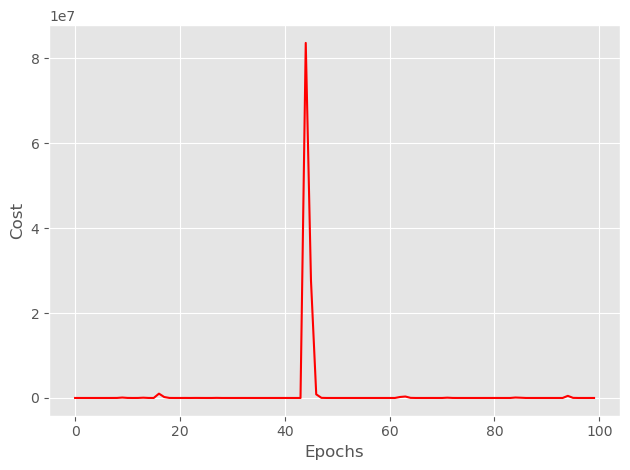

In [235]:
from matplotlib import pyplot as plt

cost_avgs = [np.mean(x) for x in neural_network.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

### 2.2 Normalizing Continuous Numeric Data

In [236]:
X_train_norm = X_train.select_dtypes(include=[np.number])
X_test_norm = X_test.select_dtypes(include=[np.number])

# Z-score normalize the data
X_train_norm = (X_train_norm - X_train_norm.mean()) / X_train_norm.std()
X_test_norm = (X_test_norm - X_test_norm.mean()) / X_test_norm.std()

neural_network_2 = TwoLayerPerceptron(n_hidden=30, 
                                    C=1, # tradeoff L2 regularizer
                                    epochs=100, # iterations
                                    eta=0.1,  # learning rate
                                    random_state=1,
                                    minibatches=len(X_train)/32)

neural_network_2.fit(X_train_norm, y_train, print_progress=50)
yhat_2 = neural_network_2.predict(X_test_norm)

print('Accuracy:', accuracy_score(y_test, yhat_2))

Epoch: 100/100

Accuracy: 0.26244499449944997


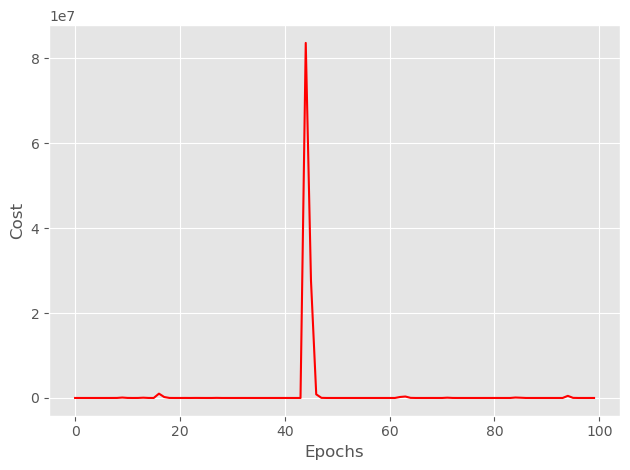

In [237]:
cost_avgs = [np.mean(x) for x in neural_network.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

### 2.3 One Hot Encoding Categorical Data

In [238]:
# What categorical variables would we encode?

### 2.4 Comparison

## 3. Modeling
### 3.1 Adding a Third Layer

### 3.2 Adding a Fourth Layer

### 3.3 Adding a Fifth Layer

### 3.4 Implementing Adaptive Learning (RENAME TO WHICHEVER ONE WE CHOOSE)

## 4. Adaptive Momentum (AdaM)
### 4.1 Implementing Adaptive Momentum

### 4.2 Quantifying the Performance